In [1]:
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error



pd.options.display.float_format = '{:,.2f}'.format
print("Tüm kütüphaneler yüklendi.")


DATA_PATH = "/kaggle/input/datathon-2025"
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

# Session value kontrolleri
train_labels = train_df[['user_session', 'session_value']].drop_duplicates().copy()
train_df = train_df.drop('session_value', axis=1)

# Event type kontrolü
print(f"\n Event types: {train_df['event_type'].value_counts().to_dict()}")

# Veri setlerini birleştirme
df = pd.concat([train_df, test_df], ignore_index=True, sort=False)
df['event_time'] = pd.to_datetime(df['event_time'])
print(f"\n Birleştirilmiş veri boyutu: {df.shape}")



Tüm kütüphaneler yüklendi.

 Event types: {'VIEW': 58829, 'ADD_CART': 42304, 'REMOVE_CART': 25615, 'BUY': 14471}

 Birleştirilmiş veri boyutu: (204170, 6)


session_value Temel İstatistikler:
count   70,736.00
mean        42.20
std         47.55
min          5.38
25%         18.53
50%         30.75
75%         46.62
max      2,328.66
Name: session_value, dtype: float64

Eksik Değer Sayısı: 0
Minimum Değer: 5.38
Maksimum Değer: 2328.66

Çeyreklik Değerler (Quantiles):
0.25    18.53
0.50    30.75
0.75    46.62
0.90    86.48
0.95   121.33
0.99   225.40
Name: session_value, dtype: float64


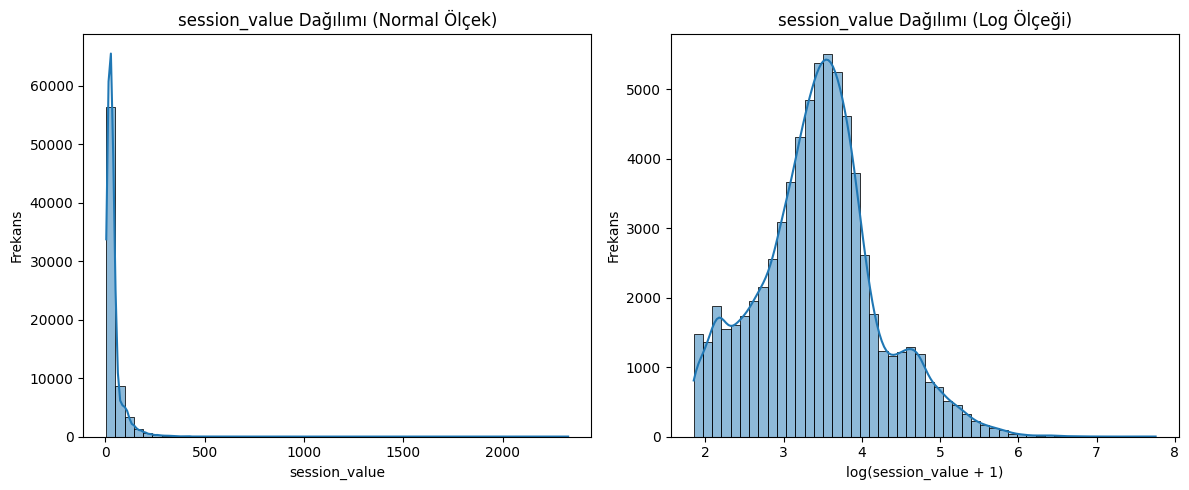


Yüksek Değerli Oturumlar (session_value > 1000):
Sayı: 7
Yüzde: 0.01%
Ortalama: 1575.19
Minimum: 1051.66
Maksimum: 2328.66


In [2]:
# train_df'deki session_value dağılımı
session_value = train_labels['session_value']

# 1. Temel İstatistikler
print("session_value Temel İstatistikler:")
print(session_value.describe())
print(f"\nEksik Değer Sayısı: {session_value.isnull().sum()}")
print(f"Minimum Değer: {session_value.min():.2f}")
print(f"Maksimum Değer: {session_value.max():.2f}")

# 2. Çeyreklik (Quantile) Analizi
quantiles = session_value.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\nÇeyreklik Değerler (Quantiles):")
print(quantiles)

# 3. Histogram (Normal ve Log Ölçeği)
plt.figure(figsize=(12, 5))

# Normal ölçek
plt.subplot(1, 2, 1)
sns.histplot(session_value, bins=50, kde=True)
plt.title('session_value Dağılımı (Normal Ölçek)')
plt.xlabel('session_value')
plt.ylabel('Frekans')

# Log ölçeği
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(session_value), bins=50, kde=True)
plt.title('session_value Dağılımı (Log Ölçeği)')
plt.xlabel('log(session_value + 1)')
plt.ylabel('Frekans')
plt.tight_layout()
plt.show()


# 4. Yüksek Değerli Oturumlar (session_value > 1000) Analizi
high_value_sessions = session_value[session_value > 1000]
print(f"\nYüksek Değerli Oturumlar (session_value > 1000):")
print(f"Sayı: {len(high_value_sessions)}")
print(f"Yüzde: {100 * len(high_value_sessions) / len(session_value):.2f}%")
print(f"Ortalama: {high_value_sessions.mean():.2f}")
print(f"Minimum: {high_value_sessions.min():.2f}")
print(f"Maksimum: {high_value_sessions.max():.2f}")

In [3]:
# Event type için one-hot encoding
event_dummies = pd.get_dummies(df['event_type'], prefix='event')
df = pd.concat([df, event_dummies], axis=1)

# Bool tiplerini int'e çevirme
for col in event_dummies.columns:
    df[col] = df[col].astype(int)

print(f"Event dummies oluşturuldu: {event_dummies.columns.tolist()}") #bunlarin hepsi bir kolon true ise 1 degeri var
print(f"\n Event dummies veri tipleri: {df[event_dummies.columns].dtypes.to_dict()}")

# kategorik degiskenler icin label encoding- hepsi icin int degerinde id lere donüşturduk
le_product = LabelEncoder()
le_category = LabelEncoder()
le_user = LabelEncoder()

df['product_id_encoded'] = le_product.fit_transform(df['product_id'])
df['category_id_encoded'] = le_category.fit_transform(df['category_id'])
df['user_id_encoded'] = le_user.fit_transform(df['user_id'])

# zaman ozellikleri
df['hour'] = df['event_time'].dt.hour
df['dayofweek'] = df['event_time'].dt.dayofweek
df['day'] = df['event_time'].dt.day
df['month'] = df['event_time'].dt.month
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
df['is_evening'] = ((df['hour'] >= 18) | (df['hour'] <= 6)).astype(int)
df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)

Event dummies oluşturuldu: ['event_ADD_CART', 'event_BUY', 'event_REMOVE_CART', 'event_VIEW']

 Event dummies veri tipleri: {'event_ADD_CART': dtype('int64'), 'event_BUY': dtype('int64'), 'event_REMOVE_CART': dtype('int64'), 'event_VIEW': dtype('int64')}


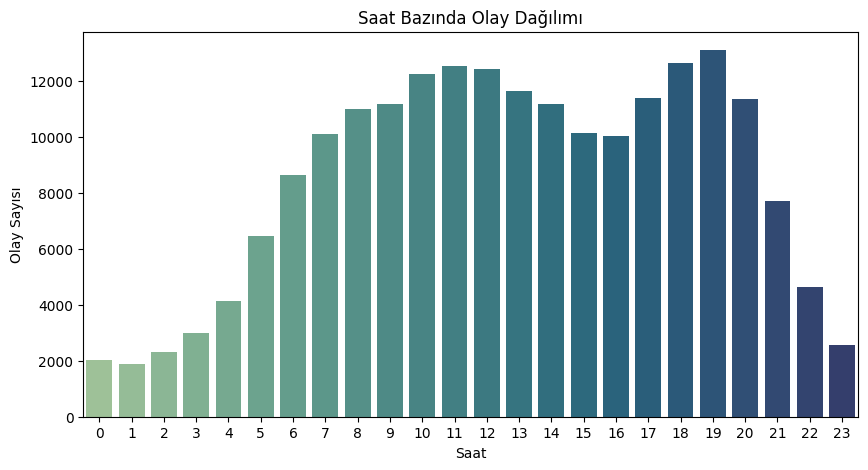

In [4]:
#Saat bazlı oturum dağılımı
plt.figure(figsize=(10,5))
sns.countplot(x='hour', data=df, palette="crest")
plt.title("Saat Bazında Olay Dağılımı")
plt.xlabel("Saat")
plt.ylabel("Olay Sayısı")
plt.show()

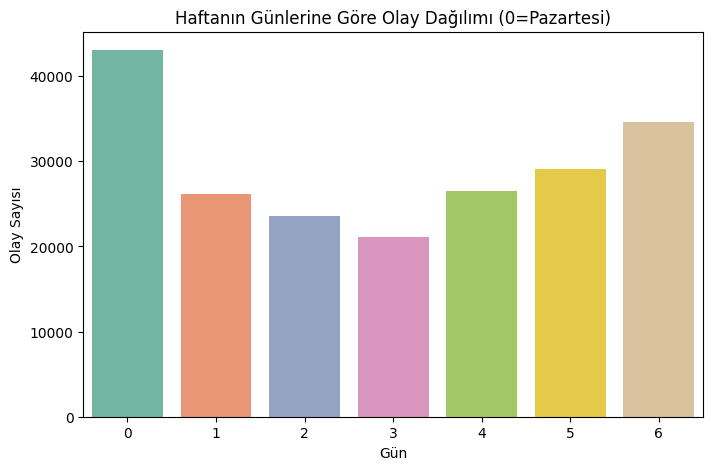

In [5]:
#Gün bazlı oturum yoğunluğu
plt.figure(figsize=(8,5))
sns.countplot(x='dayofweek', data=df, palette="Set2")
plt.title("Haftanın Günlerine Göre Olay Dağılımı (0=Pazartesi)")
plt.xlabel("Gün")
plt.ylabel("Olay Sayısı")
plt.show()

In [6]:
df.head()


,event_time,event_type,product_id,category_id,user_id,user_session,event_ADD_CART,event_BUY,event_REMOVE_CART,event_VIEW,product_id_encoded,category_id_encoded,user_id_encoded,hour,dayofweek,day,month,is_weekend,is_evening,is_business_hours
0,2025-06-19 10:23:07+00:00,ADD_CART,PROD_011223,CAT_00054,USER_097562,SESSION_158779,1,0,0,0,10073,53,59944,10,3,19,6,0,0,1
1,2025-06-07 21:34:45+00:00,ADD_CART,PROD_005519,CAT_00144,USER_006535,SESSION_029987,1,0,0,0,4948,142,4435,21,5,7,6,1,1,0
2,2025-06-21 21:29:09+00:00,ADD_CART,PROD_000577,CAT_00273,USER_047199,SESSION_022134,1,0,0,0,528,268,31080,21,5,21,6,1,1,0
3,2025-06-09 09:10:20+00:00,ADD_CART,PROD_019235,CAT_00442,USER_082028,SESSION_161308,1,0,0,0,16983,435,50906,9,0,9,6,0,0,1
4,2025-06-19 11:13:58+00:00,ADD_CART,PROD_001702,CAT_00025,USER_096574,SESSION_182859,1,0,0,0,1516,24,59387,11,3,19,6,0,0,1


In [7]:
# Ürün popülerliği
product_counts = df['product_id'].value_counts().to_dict()
df['product_popularity'] = df['product_id'].map(product_counts)

# Kategori popülerliği
category_counts = df['category_id'].value_counts().to_dict()
df['category_popularity'] = df['category_id'].map(category_counts)

# Kullanıcı aktivitesi
user_activity = df['user_id'].value_counts().to_dict()
df['user_activity_level'] = df['user_id'].map(user_activity)


# Ürün-Kategori çeşitliliği
product_cat_diversity = df.groupby('product_id')['category_id'].nunique().to_dict()
df['product_cat_diversity'] = df['product_id'].map(product_cat_diversity)

# Kategori-Ürün yoğunluğu
cat_product_density = df.groupby('category_id')['product_id'].nunique().to_dict()
df['cat_product_density'] = df['category_id'].map(cat_product_density)

# Kullanıcı çeşitliliği
user_product_diversity = df.groupby('user_id')['product_id'].nunique().to_dict()
user_category_diversity = df.groupby('user_id')['category_id'].nunique().to_dict()

df['user_product_diversity'] = df['user_id'].map(user_product_diversity)
df['user_category_diversity'] = df['user_id'].map(user_category_diversity)

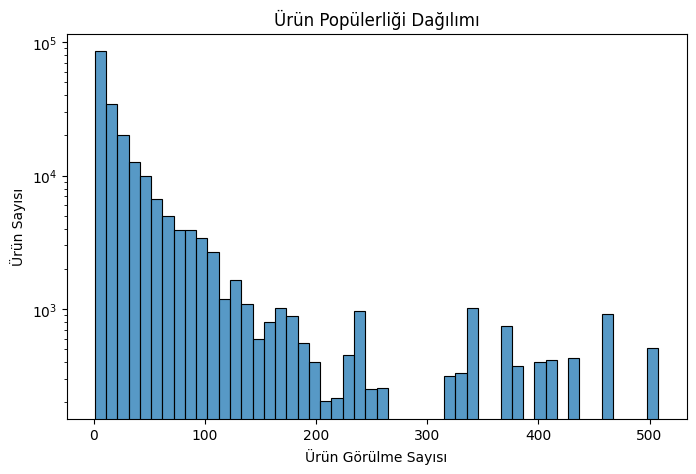

In [8]:
#Ürün Popülerliği Dağılımı
plt.figure(figsize=(8,5))
sns.histplot(df['product_popularity'], bins=50, kde=False)
plt.title("Ürün Popülerliği Dağılımı")
plt.xlabel("Ürün Görülme Sayısı")
plt.ylabel("Ürün Sayısı")
plt.yscale("log")  
plt.show()

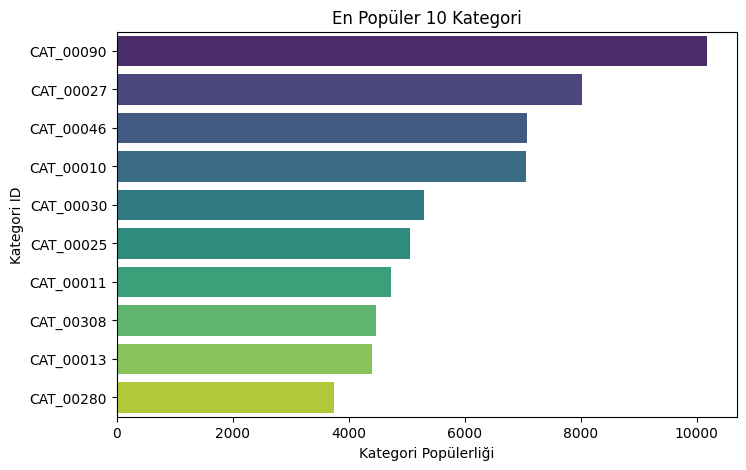

In [9]:
#Kategori Popülerliği (Top 10)
top_cats = df.groupby('category_id')['category_popularity'].first().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis")
plt.title("En Popüler 10 Kategori")
plt.xlabel("Kategori Popülerliği")
plt.ylabel("Kategori ID")
plt.show()

In [10]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id', 'user_id',
       'user_session', 'event_ADD_CART', 'event_BUY', 'event_REMOVE_CART',
       'event_VIEW', 'product_id_encoded', 'category_id_encoded',
       'user_id_encoded', 'hour', 'dayofweek', 'day', 'month', 'is_weekend',
       'is_evening', 'is_business_hours', 'product_popularity',
       'category_popularity', 'user_activity_level', 'product_cat_diversity',
       'cat_product_density', 'user_product_diversity',
       'user_category_diversity'],
      dtype='object')

In [11]:
# Oturum içi sıralama
df = df.sort_values(['user_session', 'event_time'])
df['event_order'] = df.groupby('user_session').cumcount() + 1
df['reverse_event_order'] = df.groupby('user_session')['event_order'].transform('max') - df['event_order'] + 1

# Zamansal özellikler
df['time_since_prev'] = df.groupby('user_session')['event_time'].diff().dt.total_seconds().fillna(0)
df['is_quick_action'] = (df['time_since_prev'] <= 5).astype(int)

session_agg = {
    # Temel sayılar
    'event_time': ['count', 'min', 'max'],
    'product_id': 'nunique',
    'category_id': 'nunique',
    'user_id': 'first',
    
    # Event özellikleri (eğer varsa)
    'hour': ['mean', 'std'],
    'is_weekend': ['mean', 'sum'],
    'is_evening': ['mean', 'sum'],
    'is_business_hours': ['mean'],
    
    # Popülerlik özellikleri
    'product_popularity': ['mean', 'max', 'min'],
    'category_popularity': ['mean', 'max', 'min'],
    'user_activity_level': 'first',
    'product_cat_diversity': ['mean', 'max'],
    'cat_product_density': ['mean', 'max'],
    'user_product_diversity': 'first',
    'user_category_diversity': 'first',
    # Davranış özellikleri
    'event_order': 'max',
    'is_quick_action': ['sum', 'mean'],
    'time_since_prev': ['mean', 'std', 'sum']
}

# Event type kolonları varsa ekle (sadece binary/numeric olanlar)
event_cols = []
for col in df.columns:
    if col.startswith('event_') and col != 'event_time':
        if pd.api.types.is_numeric_dtype(df[col]):
            event_cols.append(col)
            session_agg[col] = 'sum'
session_df = df.groupby('user_session').agg(session_agg)

# Kolon isimlerini düzenle
session_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in session_df.columns]
session_df.reset_index(inplace=True)


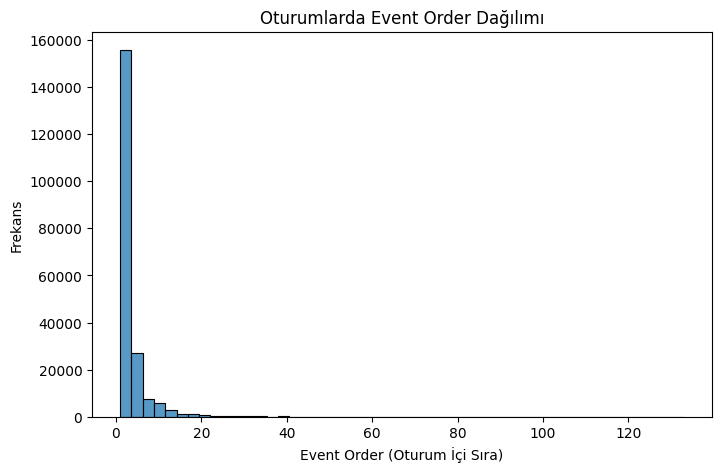

In [12]:
#Event Order Analizi
plt.figure(figsize=(8,5))
sns.histplot(df['event_order'], bins=50, kde=False)
plt.title("Oturumlarda Event Order Dağılımı")
plt.xlabel("Event Order (Oturum İçi Sıra)")
plt.ylabel("Frekans")
plt.show()

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
event_ADD_CART,"204,170.00",0.29,0.45,0.00,0.00,0.00,1.00,1.00
event_BUY,"204,170.00",0.10,0.31,0.00,0.00,0.00,0.00,1.00
event_REMOVE_CART,"204,170.00",0.18,0.39,0.00,0.00,0.00,0.00,1.00
event_VIEW,"204,170.00",0.42,0.49,0.00,0.00,0.00,1.00,1.00
product_id_encoded,"204,170.00","13,079.73","8,440.39",0.00,"5,804.00","12,511.00","20,177.75","29,381.00"
category_id_encoded,"204,170.00",143.91,123.13,0.00,29.00,111.00,244.00,451.00
user_id_encoded,"204,170.00","29,793.00","19,788.68",0.00,"13,012.00","26,934.50","45,860.75","69,865.00"
hour,"204,170.00",12.85,5.48,0.00,9.00,13.00,18.00,23.00
dayofweek,"204,170.00",2.92,2.18,0.00,1.00,3.00,5.00,6.00
day,"204,170.00",15.42,9.03,1.00,7.00,15.00,23.00,30.00


In [14]:
# Oturum süresi
if 'event_time_max' in session_df.columns and 'event_time_min' in session_df.columns:
    session_df['session_duration_seconds'] = (session_df['event_time_max'] - session_df['event_time_min']).dt.total_seconds()
    session_df['events_per_minute'] = session_df['event_time_count'] / ((session_df['session_duration_seconds'] + 1) / 60)

# ADD_CART oranı (eğer VIEW de varsa)
if 'event_ADD_CART_sum' in session_df.columns and 'event_VIEW_sum' in session_df.columns:
    session_df['cart_to_view_ratio'] = (session_df['event_ADD_CART_sum'] + 0.5) / (session_df['event_VIEW_sum'] + 1)
elif 'event_ADD_CART_sum' in session_df.columns:
    # Sadece ADD_CART varsa, bunun event sayısına oranı
    session_df['cart_rate'] = session_df['event_ADD_CART_sum'] / session_df['event_time_count']

session_df['product_per_event'] = session_df['product_id_nunique'] / session_df['event_time_count']
session_df['category_per_product'] = session_df['category_id_nunique'] / (session_df['product_id_nunique'] + 1)

user_agg = {
    'user_session': 'nunique',
    'event_time': 'count',
    'product_id': 'nunique',
    'category_id': 'nunique',
    'user_activity_level': 'first',
    'user_product_diversity': 'first',
    'user_category_diversity': 'first'
}

for col in event_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        user_agg[col] = 'sum'

user_df = df.groupby('user_id').agg(user_agg)
user_df.columns = ['user_' + '_'.join(col).strip() if isinstance(col, tuple) else 'user_' + col for col in user_df.columns]
user_df.reset_index(inplace=True)

# Kullanıcı davranış skorları 
event_time_col = [col for col in user_df.columns if 'event_time' in col and 'count' in col]
session_col = [col for col in user_df.columns if 'session' in col and 'nunique' in col]
product_col = [col for col in user_df.columns if 'product_id' in col and 'nunique' in col]

if event_time_col and session_col:
    user_df['user_events_per_session'] = user_df[event_time_col[0]] / user_df[session_col[0]]

if product_col and session_col:
    user_df['user_products_per_session'] = user_df[product_col[0]] / user_df[session_col[0]]


In [15]:
final_df = pd.merge(session_df, user_df, left_on='user_id_first', right_on='user_id', how='left')

# Etkileşim özellikleri - güvenli kolon bulma
try:
    event_count_col = [col for col in final_df.columns if 'event_time_count' in col][0]
    user_event_col = [col for col in final_df.columns if 'user_event_time' in col][0]
    final_df['session_vs_user_activity'] = final_df[event_count_col] / (final_df[user_event_col] + 1)
except:
    print("Session vs user activity özelliği atlandı")

try:
    product_nunique_col = [col for col in final_df.columns if 'product_id_nunique' in col][0]
    user_product_col = [col for col in final_df.columns if 'user_product_id' in col][0]
    final_df['session_vs_user_products'] = final_df[product_nunique_col] / (final_df[user_product_col] + 1)
except:
    print("Session vs user products özelliği atlandı")


In [16]:
final_df.describe().T


,count,mean,std,min,25%,50%,75%,max
event_time_count,"101,315.00",2.02,2.62,1.00,1.00,1.00,2.00,133.00
product_id_nunique,"101,315.00",1.90,2.36,1.00,1.00,1.00,2.00,125.00
category_id_nunique,"101,315.00",1.52,1.29,1.00,1.00,1.00,1.00,71.00
hour_mean,"101,315.00",12.62,5.46,0.00,8.00,12.88,17.00,23.00
hour_std,"34,704.00",0.38,1.17,0.00,0.00,0.00,0.50,16.26
is_weekend_mean,"101,315.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
is_weekend_sum,"101,315.00",0.63,1.69,0.00,0.00,0.00,1.00,100.00
is_evening_mean,"101,315.00",0.39,0.48,0.00,0.00,0.00,1.00,1.00
is_evening_sum,"101,315.00",0.79,1.85,0.00,0.00,0.00,1.00,100.00
is_business_hours_mean,"101,315.00",0.50,0.50,0.00,0.00,0.60,1.00,1.00


In [17]:
final_df.isnull().sum()

user_session                         0
event_time_count                     0
event_time_min                       0
event_time_max                       0
product_id_nunique                   0
category_id_nunique                  0
user_id_first                        0
hour_mean                            0
hour_std                         66611
is_weekend_mean                      0
is_weekend_sum                       0
is_evening_mean                      0
is_evening_sum                       0
is_business_hours_mean               0
product_popularity_mean              0
product_popularity_max               0
product_popularity_min               0
category_popularity_mean             0
category_popularity_max              0
category_popularity_min              0
user_activity_level_first            0
product_cat_diversity_mean           0
product_cat_diversity_max            0
cat_product_density_mean             0
cat_product_density_max              0
user_product_diversity_fi

In [18]:
# Sonsuz ve NaN değerleri temizle
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_df.fillna(0, inplace=True)

# Datetime kolonları çıkar
datetime_cols = [col for col in final_df.columns if 'time' in col.lower() and final_df[col].dtype == 'datetime64[ns]']
final_df = final_df.drop(columns=datetime_cols, errors='ignore')

# Hedef değişken ekleme
final_df = pd.merge(final_df, train_labels, on='user_session', how='left')
final_df['session_value'] = final_df['session_value'].fillna(0)
final_df.loc[final_df['session_value'] < 0, 'session_value'] = 0
final_df['session_value_log'] = np.log1p(final_df['session_value'])

print(f"Temizlik tamamlandı. Son boyut: {final_df.shape}")

Temizlik tamamlandı. Son boyut: (101315, 59)


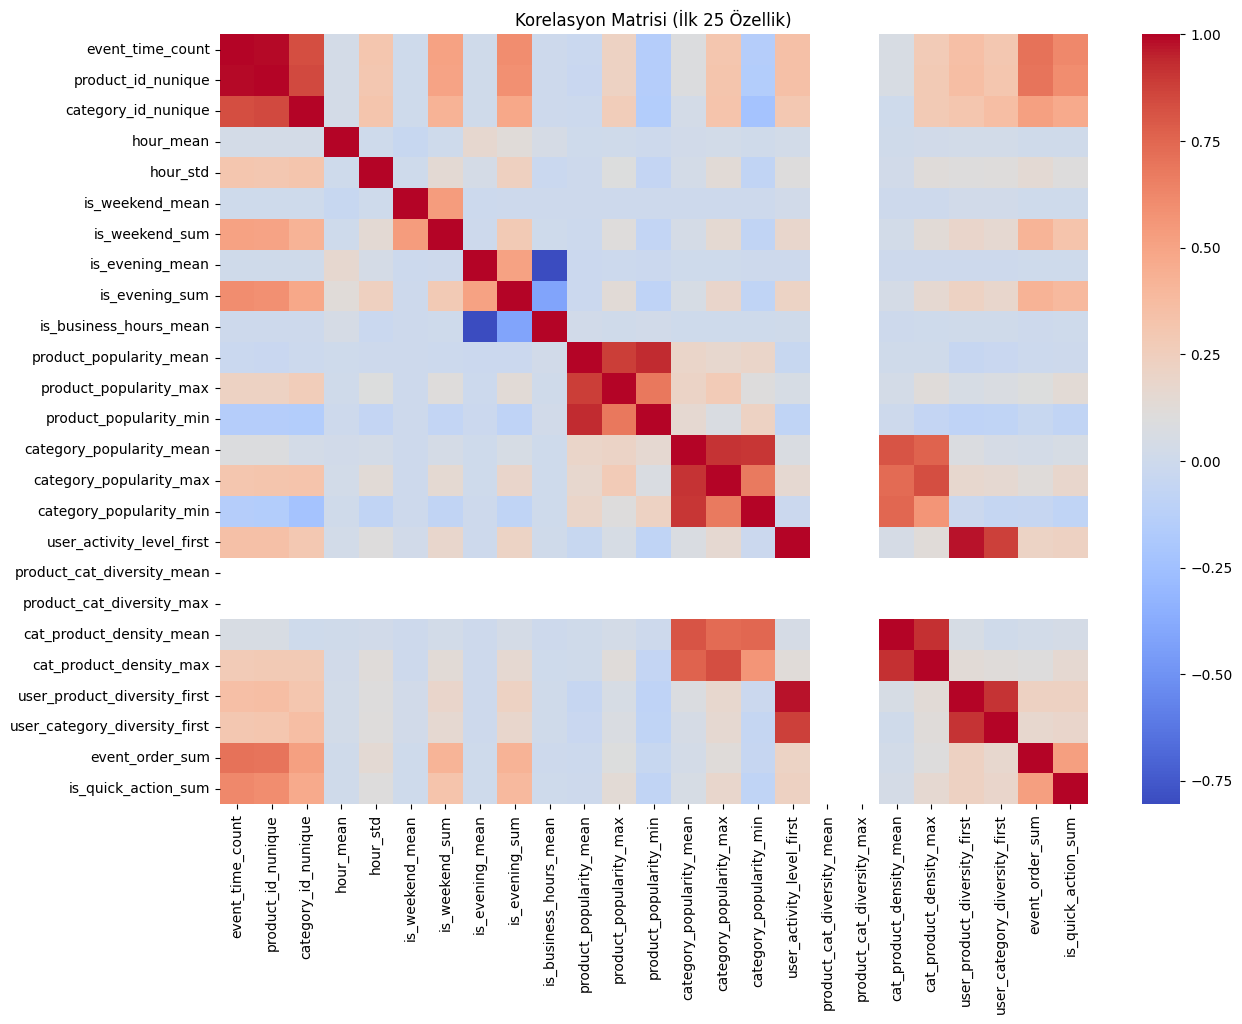

In [19]:
# Korelasyon matrisi (ilk 25 özellik için)
plt.figure(figsize=(14, 10))
corr = final_df.corr(numeric_only=True)   # sadece sayısal kolonları alır
sns.heatmap(corr.iloc[:25, :25], cmap='coolwarm', annot=False)
plt.title("Korelasyon Matrisi (İlk 25 Özellik)")
plt.show()

In [20]:
from sklearn.feature_selection import VarianceThreshold

# 1. Gerekli bağımlılıkları kontrol et
if 'train_df' not in globals():
    raise NameError("train_df tanımlı değil. Lütfen train_df'nin yüklendiğinden emin olun.")
if 'final_df' not in globals():
    raise NameError("final_df tanımlı değil. Lütfen önceki adımları kontrol edin.")

# Train session'ları tanımla
try:
    train_sessions = train_df['user_session'].unique()
except NameError:
    raise NameError("train_df veya user_session sütunu eksik. Veri yükleme adımlarını kontrol edin.")

# 2. Sayısal sütunları belirle
exclude_cols = ['user_session', 'user_id', 'user_id_first', 'session_value', 'session_value_log']
feature_cols = [col for col in final_df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(final_df[col])]

# Hata kontrolü: feature_cols boş mu?
if not feature_cols:
    raise ValueError("Hiç sayısal özellik bulunamadı. final_df sütunlarını kontrol edin: " + str(final_df.columns.tolist()))

# 3. Eğitim verisini hazırla
train_final = final_df[final_df['user_session'].isin(train_sessions)].copy()
if train_final.empty:
    raise ValueError("train_final boş. train_sessions ile final_df uyumsuz. Session'ları kontrol edin.")

X = train_final[feature_cols].fillna(0)
y_log = train_final['session_value_log']

# Hata kontrolü: X ve y_log uygun mu?
if X.empty or y_log.empty:
    raise ValueError("X veya y_log boş. Eğitim verisi oluşturulamadı.")

# 4. Özellik önemi analizi (XGBoost ile)
temp_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
temp_model.fit(X, y_log)

# Özellik önemlerini al
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': temp_model.feature_importances_
})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

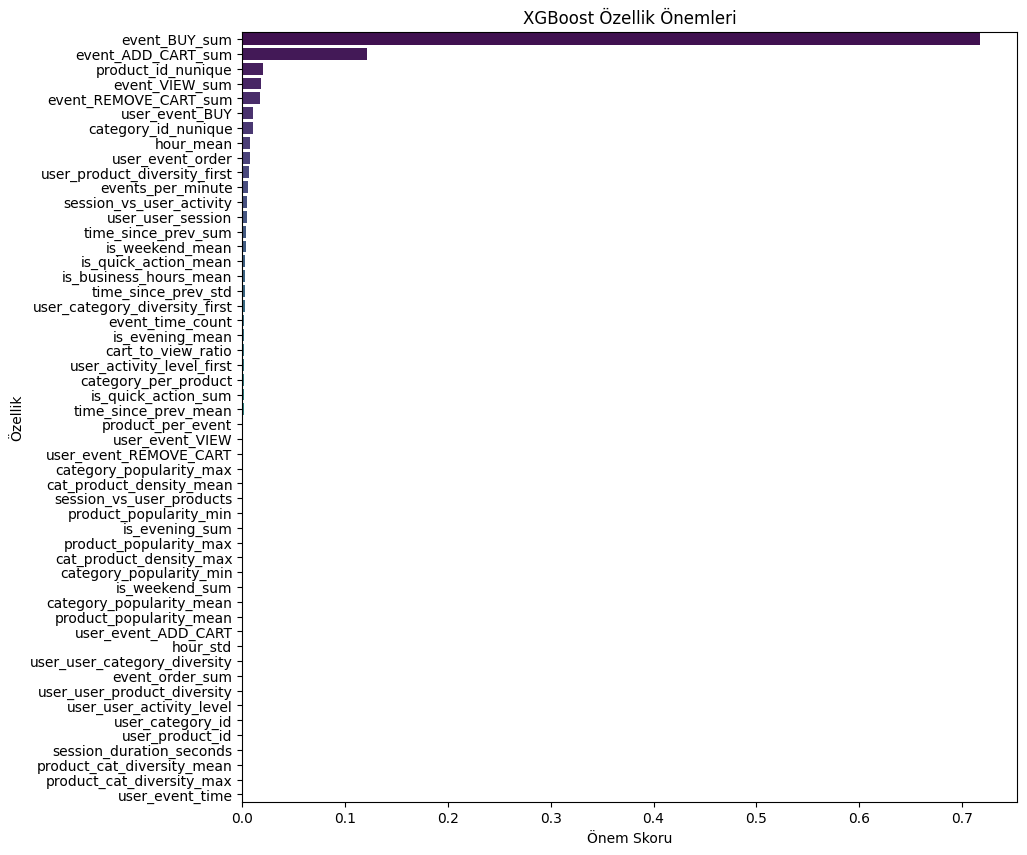

In [21]:
#XGBoost Özellik Önemleri
top_features = feature_importance

plt.figure(figsize=(10,10))
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title("XGBoost Özellik Önemleri")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellik")
plt.show()

In [22]:
# Önem eşiği: En düşük %35'i ele
importance_threshold = feature_importance['importance'].quantile(0.35)
selected_features = feature_importance[feature_importance['importance'] > importance_threshold]['feature'].tolist()
print(f"Seçilen özellik sayısı (önem eşiği sonrası): {len(selected_features)}")

# 5. Korelasyon analizi
corr_matrix = final_df[selected_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Yüksek korelasyonlu özellikleri bul (eşik: 0.90)
to_drop = []
for column in upper.columns:
    for row in upper.index:
        if upper.loc[row, column] > 0.90 and row in selected_features and column in selected_features:
            if feature_importance[feature_importance['feature'] == row]['importance'].iloc[0] < \
               feature_importance[feature_importance['feature'] == column]['importance'].iloc[0]:
                to_drop.append(row)
            else:
                to_drop.append(column)

to_drop = list(set(to_drop))
selected_features = [col for col in selected_features if col not in to_drop]
print(f"Korelasyon sonrası seçilen özellik sayısı: {len(selected_features)}")

# 6. Düşük varyanslı özellikleri çıkar
selector = VarianceThreshold(threshold=0.01)
selector.fit(final_df[selected_features])
selected_features = [selected_features[i] for i in range(len(selected_features)) if selector.get_support()[i]]
print(f"Varyans eşiği sonrası seçilen özellik sayısı: {len(selected_features)}")

# 7. final_df'yi güncelle
keep_cols = selected_features + ['user_session', 'user_id', 'user_id_first', 'session_value', 'session_value_log']
final_df = final_df[keep_cols].copy()

print(f"Gereksiz veriler azaltıldı. Yeni boyut: {final_df.shape}")
print(f"final_df sütunları: {final_df.columns.tolist()}")

Seçilen özellik sayısı (önem eşiği sonrası): 34
Korelasyon sonrası seçilen özellik sayısı: 29
Varyans eşiği sonrası seçilen özellik sayısı: 29
Gereksiz veriler azaltıldı. Yeni boyut: (101315, 34)
final_df sütunları: ['event_BUY_sum', 'event_ADD_CART_sum', 'product_id_nunique', 'event_VIEW_sum', 'event_REMOVE_CART_sum', 'user_event_BUY', 'category_id_nunique', 'hour_mean', 'user_event_order', 'user_product_diversity_first', 'events_per_minute', 'session_vs_user_activity', 'user_user_session', 'time_since_prev_sum', 'is_weekend_mean', 'is_quick_action_mean', 'is_business_hours_mean', 'time_since_prev_std', 'is_evening_mean', 'cart_to_view_ratio', 'category_per_product', 'is_quick_action_sum', 'product_per_event', 'user_event_VIEW', 'user_event_REMOVE_CART', 'category_popularity_max', 'cat_product_density_mean', 'product_popularity_min', 'is_evening_sum', 'user_session', 'user_id', 'user_id_first', 'session_value', 'session_value_log']


In [23]:
# Train-test ayrımı
train_sessions = train_df['user_session'].unique()
test_sessions = test_df['user_session'].unique()

train_final = final_df[final_df['user_session'].isin(train_sessions)].copy()
test_final = final_df[final_df['user_session'].isin(test_sessions)].copy()

# Feature selection
exclude_cols = ['user_session', 'user_id', 'user_id_first', 'session_value', 'session_value_log']
feature_cols = [col for col in final_df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(final_df[col])]

X = train_final[feature_cols].fillna(0)
y_log = train_final['session_value_log']
X_test = test_final[feature_cols].fillna(0)

print(f"Eğitim seti: {X.shape}")
print(f"Test seti: {X_test.shape}")
print(f"Kullanılan özellik sayısı: {len(feature_cols)}")

Eğitim seti: (70736, 29)
Test seti: (30789, 29)
Kullanılan özellik sayısı: 29


In [24]:

print(" XGB MODEL:")


# Train-test ayrımı
train_sessions = train_df['user_session'].unique()
test_sessions = test_df['user_session'].unique()

train_final = final_df[final_df['user_session'].isin(train_sessions)].copy()
test_final = final_df[final_df['user_session'].isin(test_sessions)].copy()

# Feature selection
exclude_cols = ['user_session', 'user_id', 'user_id_first', 'session_value', 'session_value_log']
feature_cols = [col for col in final_df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(final_df[col])]

X = train_final[feature_cols].fillna(0)
y_log = train_final['session_value_log']
y_normal = train_final['session_value']
X_test = test_final[feature_cols].fillna(0)
xgb_model = xgb.XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            reg_alpha=0.1,
            reg_lambda=0.1,
            eval_metric='rmse'
        )
# Cross Validation (log scale)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X, y_log, cv=kfold, scoring='neg_root_mean_squared_error', n_jobs=-1)
cv_rmse_log = -cv_scores.mean()
cv_rmse_log_std = cv_scores.std()

# Model eğitimi
xgb_model.fit(X, y_log)

# Train performans (normal scale)
train_pred_log = xgb_model.predict(X)
train_pred_normal = np.expm1(train_pred_log)
train_pred_normal = np.maximum(train_pred_normal, 0)  # Negatif değerleri sıfır yap

train_mse_normal = mean_squared_error(y_normal, train_pred_normal)
train_rmse_normal = np.sqrt(train_mse_normal)

# Test tahminleri
test_pred_log = xgb_model.predict(X_test)
test_pred_normal = np.expm1(test_pred_log)
test_pred_normal = np.maximum(test_pred_normal, 0)  # Negatif değerleri sıfır yap

print(f"test tahmin aralığı: {test_pred_normal.min():.2f} - {test_pred_normal.max():.2f}")

print(f"CV RMSE (log scale):     {cv_rmse_log:.4f} ± {cv_rmse_log_std:.4f}")
print(f"Train MSE (normal):      {train_mse_normal:.2f}")
print(f"Train RMSE (normal):     {train_rmse_normal:.2f}")
print(f"Test tahmin aralığı:     {test_pred_normal.min():.2f} - {test_pred_normal.max():.2f}")

 XGB MODEL:
test tahmin aralığı: 7.09 - 2288.78
CV RMSE (log scale):     0.4453 ± 0.0013
Train MSE (normal):      154.83
Train RMSE (normal):     12.44
Test tahmin aralığı:     7.09 - 2288.78


In [25]:
submission = pd.DataFrame({
    'user_session': test_final['user_session'],
    'session_value': test_pred_normal
})

submission.to_csv('submission.csv', index=False, float_format='%.4f')
print(f"submission.csv dosyası oluşturuldu.")
print(f"Submission boyutu: {submission.shape}")
print(f"Submission değer aralığı: {submission['session_value'].min():.2f} - {submission['session_value'].max():.2f}")


submission.csv dosyası oluşturuldu.
Submission boyutu: (30789, 2)
Submission değer aralığı: 7.09 - 2288.78


In [26]:
submission.head(10)

,user_session,session_value
0,SESSION_000000,282.54
5,SESSION_000013,12.51
7,SESSION_000022,45.87
8,SESSION_000024,19.11
9,SESSION_000025,33.52
10,SESSION_000026,25.13
11,SESSION_000033,21.79
18,SESSION_000045,21.63
20,SESSION_000051,25.04
22,SESSION_000056,22.87


[I 2025-08-30 19:20:16,545] A new study created in memory with name: no-name-2dcdb85a-0ca3-4bda-bc6d-b7624894deee
[I 2025-08-30 19:20:21,828] Trial 0 finished with value: 15.149003608241372 and parameters: {'n_estimators': 803, 'max_depth': 4, 'learning_rate': 0.02529987845086735, 'subsample': 0.8277619880827692, 'colsample_bytree': 0.7013757857675973, 'reg_alpha': 0.4374583609123158, 'reg_lambda': 0.2871261181546095, 'min_child_weight': 2}. Best is trial 0 with value: 15.149003608241372.
[I 2025-08-30 19:20:27,660] Trial 1 finished with value: 15.868759108691465 and parameters: {'n_estimators': 652, 'max_depth': 5, 'learning_rate': 0.012731437649351007, 'subsample': 0.8571232235071483, 'colsample_bytree': 0.6533163411293552, 'reg_alpha': 0.11430271680279959, 'reg_lambda': 0.8771114841024701, 'min_child_weight': 10}. Best is trial 0 with value: 15.149003608241372.
[I 2025-08-30 19:20:32,666] Trial 2 finished with value: 16.27960659666211 and parameters: {'n_estimators': 326, 'max_depth

En iyi parametreler: {'n_estimators': 622, 'max_depth': 5, 'learning_rate': 0.05131302374179563, 'subsample': 0.9744009719195355, 'colsample_bytree': 0.9071122811040311, 'reg_alpha': 0.10022686019577856, 'reg_lambda': 0.1050299057735497, 'min_child_weight': 3}
En iyi Custom RMSE (normal scale): 14.3559350870087


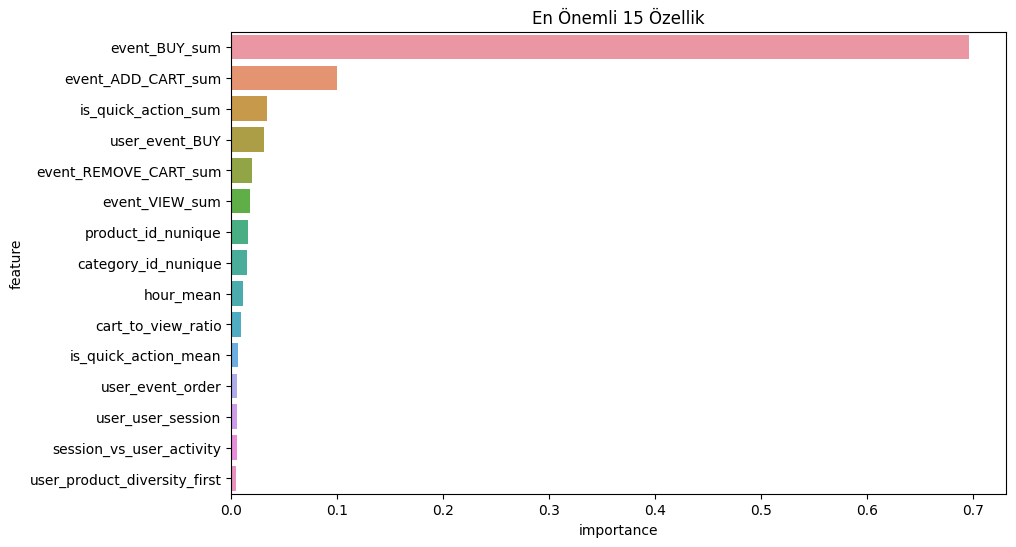

Özellik önemleri:
                          feature  importance
0                  event_BUY_sum        0.70
1             event_ADD_CART_sum        0.10
21           is_quick_action_sum        0.03
5                 user_event_BUY        0.03
4          event_REMOVE_CART_sum        0.02
3                 event_VIEW_sum        0.02
2             product_id_nunique        0.02
6            category_id_nunique        0.01
7                      hour_mean        0.01
19            cart_to_view_ratio        0.01
15          is_quick_action_mean        0.01
8               user_event_order        0.01
12             user_user_session        0.01
11      session_vs_user_activity        0.00
9   user_product_diversity_first        0.00
Yeni Train MSE (normal): 163.79
Yeni Train RMSE (normal): 12.80
Yeni Test tahmin aralığı: 7.53 - 2328.66
submission_optuna_v2.csv dosyası oluşturuldu.


In [27]:
import optuna
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Eğitim verisini hazırla
train_sessions = train_df['user_session'].unique()
test_sessions = test_df['user_session'].unique()
train_final = final_df[final_df['user_session'].isin(train_sessions)].copy()
test_final = final_df[final_df['user_session'].isin(test_sessions)].copy()

exclude_cols = ['user_session', 'user_id', 'user_id_first', 'session_value', 'session_value_log']
feature_cols = [col for col in final_df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(final_df[col])]
X = train_final[feature_cols].fillna(0)
y_log = train_final['session_value_log']
y_normal = train_final['session_value']
X_test = test_final[feature_cols].fillna(0)

# Özel loss fonksiyonu (daha fazla ağırlık)
def custom_loss(y_true, y_pred):
    y_true_normal = np.expm1(y_true)
    y_pred_normal = np.expm1(y_pred)
    weights = np.where(y_true_normal > 1000, 2.0, 1.0)  # Yüksek değerli oturumlara daha fazla ağırlık
    return np.sqrt(np.mean(weights * (y_true_normal - y_pred_normal) ** 2))

# Optuna objective fonksiyonu
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),  # Daha geniş aralık
        'max_depth': trial.suggest_int('max_depth', 3, 8),  # Daha derin ağaçlar
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Daha geniş öğrenme oranı
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'eval_metric': 'rmse'
    }
    
    # Erken durdurma
    X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
    model = XGBRegressor(**param)
    model.fit(
        X_train, y_train_log,
        eval_set=[(X_val, y_val_log)],
        early_stopping_rounds=50,
        verbose=False
    )
    
    # Custom loss
    y_pred_log = model.predict(X)
    return custom_loss(y_log, y_pred_log)

# Optuna çalıştır
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)  # Daha fazla deneme

# En iyi parametreleri yazdır
print("En iyi parametreler:", study.best_params)
print("En iyi Custom RMSE (normal scale):", study.best_value)

# En iyi model ile eğitim
best_params = study.best_params
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X, y_log)

# Özellik önemlerini görselleştir
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('En Önemli 15 Özellik')
plt.show()
print("Özellik önemleri:\n", feature_importance.head(15))

# Train performansını değerlendir
train_pred_log = xgb_model.predict(X)
train_pred_normal = np.expm1(train_pred_log)
train_pred_normal = np.maximum(train_pred_normal, 0)
train_mse_normal = mean_squared_error(y_normal, train_pred_normal)
train_rmse_normal = np.sqrt(train_mse_normal)

# Test tahminleri
test_pred_log = xgb_model.predict(X_test)
test_pred_normal = np.expm1(test_pred_log)
test_pred_normal = np.maximum(test_pred_normal, 0)
test_pred_normal = np.clip(test_pred_normal, 5.38, 2328.66)

# Sonuçları yazdır
print(f"Yeni Train MSE (normal): {train_mse_normal:.2f}")
print(f"Yeni Train RMSE (normal): {train_rmse_normal:.2f}")
print(f"Yeni Test tahmin aralığı: {test_pred_normal.min():.2f} - {test_pred_normal.max():.2f}")

# Submission oluştur
submission = pd.DataFrame({
    'user_session': test_final['user_session'],
    'session_value': test_pred_normal
})
submission.to_csv('submission_optuna_v2.csv', index=False, float_format='%.4f')
print("submission_optuna_v2.csv dosyası oluşturuldu.")